# Sedimentation of a colloidal particle

## Overview

### Questions

- How do I model a colloidal particle suspended in MPCD particles?
- How do I simulate a bulk sedimentation process?
- What are finite-size effects for sedimentation?

### Objectives

- Explain the discrete model for a colloidal particle and demonstrate how to
  setup such a model in HOOMD-blue.
- Explain the concept of sedimentation and demonstrate how to apply the
  corresponding body forces to a colloidal particle and MPCD particles.
- Demonstrate how to simulate sedimentation and measure the sedimentation
  velocity of a colloidal particle.
- Explain the origin of finite-size effects in sedimentation and show how to
  correct simulation measurements for them.

## Boilerplate code

In [1]:
import json

import gsd.hoomd
import hoomd
import hoomd.azplugins
import hoomd.mpcd
import matplotlib
import numpy

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

## Background

A colloidal particle is typically much larger than the size of an MPCD collision
cell. Hence, it cannot be modeled simply as a single particle that participates
in the collision, like we did for a monomer in a polymer chain. Multiple
approaches have been proposed for coupling colloidal particles to the MPCD fluid.
We will use the approach of [Poblete et al.](https://doi.org/10.1103/PhysRevE.90.033314),
which discretizes the surface of the particle into smaller particles.
Wani et al. showed that this approach works quite well for not only
[spherical particles](https://doi.org/10.1063/5.0075002) but also more
[complex particle shapes](https://doi.org/10.1039/D4SM00271G).

Sedimentation is the process of a colloidal particle falling through a fluid,
usually due to a density mismatch. Given enough time, the particle will come
to a steady sedimentation velocity $U$ in response to an effective force $F$
that causes it to sediment. For a single particle, the two are related through
the *drag coefficient* $\gamma$:

$$
U = F / \gamma
$$

For a sphere of diameter $d$ with a no-slip surface, $\gamma = 3 \pi \mu d$.
Let's see if MPCD can reproduce something like this!

## Initialization

We have created a discrete model of a sphere with diameter 6 for you. There
is one central particle of type A, and there are 162 surface particles of type
A-constituent. The constituent particles are bonded to their nearest neighbors
and to the central particle. We have created a file `bond_lengths.json` that
gives the approximate lengths of all these bonds. The sphere starts at the
center of a cubic simulation box with edge length $L = 30\,\ell$.

The first thing we need to do is open the GSD file for the sphere and load it
into a HOOMD snapshot.

In [2]:
with gsd.hoomd.open("sphere.gsd") as traj:
    snapshot = hoomd.Snapshot.from_gsd_frame(traj[0], hoomd.communicator.Communicator())

We want to make sure all the MD particles have the right mass and no drift in
their velocities. We set the mass of the MD particles to be the same as the mass
of MPCD particles in a collision cell. The collisions cells have unit volume by
default, so this mass is same as the number density, $\rho = 5/\ell^3$, times
the MPCD particle mass *m*. We zero all the velocities because the MPCD particles
will rethermalize them quickly later.

In [3]:
mass = 1
density = 5
kT = 1

snapshot.particles.mass[:] = mass * density
snapshot.particles.velocity[:] = 0

Then, we will add the MPCD particles to fill the box volume *V*. The number of
MPCD particles to add is $N = \rho V$. We follow essentially the same procedure
as before, except that this time we read the box from the snapshot.

In [4]:
box = hoomd.Box.from_box(snapshot.configuration.box)
rng = numpy.random.default_rng(seed=42)

snapshot.mpcd.types = ["A"]
snapshot.mpcd.N = numpy.round(density * box.volume).astype(int)
snapshot.mpcd.mass = mass
snapshot.mpcd.position[:] = box.L * rng.uniform(
    low=-0.5, high=0.5, size=(snapshot.mpcd.N, 3)
)

vel = rng.normal(loc=0.0, scale=numpy.sqrt(kT / mass), size=(snapshot.mpcd.N, 3))
vel -= numpy.mean(vel, axis=0)
snapshot.mpcd.velocity[:] = vel

simulation = hoomd.Simulation(device=hoomd.device.auto_select(), seed=1)
simulation.create_state_from_snapshot(snapshot)

Later, we are also going to need to know how many HOOMD particles make up a
sphere and how many MPCD particles there are, so let's save that while we have
the snapshot.

In [5]:
num_per_sphere = snapshot.particles.N
num_MPCD = snapshot.mpcd.N

## Configuring the MPCD integrator

Since we have regular HOOMD particles that are embedded in our MPCD particles,
we will need to configure both MD and MPCD options.

### MD configuration

We need to use a timestep that is suitable for MD. Here, we are going to be
using stiff harmonic springs to hold the discrete sphere model together, so
we select a small timestep of $0.002\,\tau$.

In [6]:
integrator = hoomd.mpcd.Integrator(dt=0.002)
simulation.operations.integrator = integrator

Since we only have one colloidal particle, we don't need a pair potential.
However, we do need bond potentials to enforce the distances between the
particles that make up the sphere. Based on experience, we use a stiff spring
constant of $5000\varepsilon/\ell^2$ for all springs. We use our JSON file of
lengths to setup the potential for all the different bond lengths we have.

In [7]:
with open("bond_lengths.json") as f:
    bond_lengths = json.load(f)

harmonic = hoomd.md.bond.Harmonic()
for bond_type, bond_length in bond_lengths.items():
    harmonic.params[bond_type] = dict(k=5000.0, r0=bond_length)
integrator.forces.append(harmonic)

(If you are interested, confirm the timestep is sufficiently small for
this spring constant by estimating the spring relaxation time.)

To simulate sedimentation, we also need to put a constant force on the particle.
We distribute this force to all the particles in the sphere, arbitrarily
choosing for it to move in the *x* direction. We are going to use a pretty large
force to make it easier to measure the motion of the sphere. In real
simulations, this force would probably be a lot smaller, especially if
simulating a suspension of particles.

In [8]:
F = 40.
all_ = hoomd.filter.All()
sphere_force = hoomd.md.force.Constant(filter=all_)
for i in ("A", "A-constituent"):
    sphere_force.constant_force[i] = (F / num_per_sphere, 0, 0)
integrator.forces.append(sphere_force)

As for the polymers, we will use a `ConstantVolume` (NVE) integration method
for the MD particles.

In [9]:
nve = hoomd.md.methods.ConstantVolume(filter=all_)
integrator.methods.append(nve)

### MPCD configuration

Now that the base MD simulation is configured, we can setup the corresponding
MPCD simulation. The collision method will be our standard SRD fluid
(collision time $\Delta t = 0.1\tau$, collision angle $\alpha = 130^\circ$, and
a thermostat to maintain constant temperature), but importantly, we now couple
the constituent particles (on the surface) to the solvent here!

In [10]:
integrator.collision_method = hoomd.mpcd.collide.StochasticRotationDynamics(
    period=numpy.round(0.1 / integrator.dt).astype(int),
    angle=130,
    kT=kT,
    embedded_particles=hoomd.filter.Type(["A-constituent"])
)

Like before, the streaming method will be `Bulk`; however, this time we need to
include a force acting on the solvent to model the sedimentation process. The
system (colloid + fluid) should have a net force of zero, so the force on the
sphere must be balanced by a force acting on all the MPCD particles. There is
only one colloidal particle, so we can divide the applied force by the number
of MPCD particles.

MPCD particles only support a limited number of body forces, and these forces
must be specified with the streaming method. We hence create the force and
streaming method at the same time:

In [11]:
solvent_force = hoomd.mpcd.force.ConstantForce((-F / num_MPCD, 0, 0))
integrator.streaming_method = hoomd.mpcd.stream.Bulk(
    period=integrator.collision_method.period,
    mpcd_particle_force=solvent_force,
)

Last, we make sure we don't forget our sorter for performance.

In [12]:
integrator.mpcd_particle_sorter = hoomd.mpcd.tune.ParticleSorter(
    trigger=integrator.collision_method.period * 20
)

## Sedimentation

### Calculating velocity

We are now ready to sample the sedimentation velocity. We can do this by
computing the average velocity of all the HOOMD particles that make up the
colloid over time. You can implement this procedure yourself
using NumPy, but it can be slow due to the large number of MPCD particles.
We will use the [VelocityCompute](https://azplugins.readthedocs.io/en/stable/module-azplugins-compute.html#hoomd.azplugins.compute.VelocityCompute)
from azplugins to do the same calculation. This compute evaluates the
mass-averaged velocity of a group of HOOMD particles and/or the MPCD particles
using the native particle data and the current device. You can then time-average
the result of this calculation in Python.

We will make two `VelocityCompute`s: one just for the colloid, and one for the
entire system. The second should always have a velocity close to zero if we have
balanced the forces correctly, so we will use this as a quick before/after
sanity check!

In [13]:
colloid_velocity = hoomd.azplugins.compute.VelocityCompute(filter=all_)
all_velocity = hoomd.azplugins.compute.VelocityCompute(
    filter=all_, include_mpcd_particles=True
)
simulation.operations.computes.extend([colloid_velocity, all_velocity])

Before we start the simulation, we can check the values of both. We see they're
both zero within floating-point error!

In [14]:
simulation.run(0)
print(colloid_velocity.velocity)
print(all_velocity.velocity)

(0.0, 0.0, 0.0)
(9.280537494804994e-18, -2.7071572290624238e-17, 7.35707191519818e-18)


### Warmup

Now, we need to run the simulation long enough that the colloidal particle
reaches a steady-state velocity. Let's monitor the *x* component of its velocity
in a sequence of short runs. This warmup will run for 1000 collisions ($100\tau$).

In [15]:
num_samples = 100
num_steps_per_sample = 10 * integrator.collision_method.period
times = numpy.zeros(num_samples, dtype=int)
velocity = numpy.zeros(num_samples)
for i in range(num_samples):
    simulation.run(num_steps_per_sample)
    times[i] = simulation.timestep * integrator.dt
    velocity[i] = colloid_velocity.velocity[0]

We see that the particle velocity quickly becomes nonzero, and it seems to be
fluctuating around about $0.1\ell/\tau$ but with a pretty large spread. We
should be able to get a decent average with frequent sampling, though.

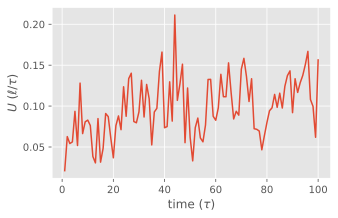

In [16]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(times, velocity)
ax.set_xlabel(r"time ($\tau$)")
ax.set_ylabel(r"$U$ ($\ell/\tau$)")
fig

As a sanity check, we confirm that the total velocity of the system is still
close to zero:

In [17]:
print(all_velocity.velocity)

(-5.0507985510935175e-14, 1.9522399053195882e-17, -2.613395434765398e-17)


### Production

Now that a steady-state has been reached, we can sample the colloid velocity
frequently to compute an average. Due to the hybrid use of MD and MPCD, as well
as the periodic nature of the MPCD collisions, it is a good idea to sample the
velocity at different times relative to the collision. Sampling every collision
period plus 1 timestep is an easy way to achieve this. We will sample for
another 1000 collisions ($100\tau$).

In [18]:
num_samples = 1_000
num_steps_per_sample = integrator.collision_method.period + 1
velocity = numpy.zeros(num_samples)
for i in range(num_samples):
    simulation.run(num_steps_per_sample)
    velocity[i] = colloid_velocity.velocity[0]

Now, we calculate the average sedimentation velocity from the series of
measurements we took:

In [19]:
sedimentation_velocity = numpy.mean(velocity)
print(f"{sedimentation_velocity:.3e}")

1.172e-01


### Finite-size effects

How does the simulated velocity compare to the theoretical expectation?

In [20]:
dynamic_viscosity = 3.96
diameter = 6
drag_coefficient_theory = 3 * numpy.pi * dynamic_viscosity * diameter
sedimentation_velocity_theory = F / drag_coefficient_theory
print(f"{sedimentation_velocity_theory:.3e}")

1.786e-01


Uh oh, we're quite a bit under! One possible reason for this is the presence
of *finite-size effects* on the sedimentation process. Due to the periodic
boundary conditions, the velocity of a particle falling in an array of its
periodic images is less than if the particle fell in isolation. For a single
particle in a cubic box with edge length *L*, the finite-size correction to
the sedimentation velocity $\Delta U$ is:

$$
\Delta U = \xi \frac{F}{6 \pi \mu L}
$$

where $\xi = 2.837297$ is a constant specific to the cubic box geometry. The
theoretical formulas from our introduction to MPCD give a dynamic viscosity of
$\mu = 3.96 \varepsilon \tau/\ell^3$.

In [21]:
xi = 2.837297
L = simulation.state.box.Lx
sedimentation_velocity_corr = (
    sedimentation_velocity
    + xi * F / (6 * numpy.pi * dynamic_viscosity * L)
)
print(f"{sedimentation_velocity_corr:.3e}")

1.679e-01


Much better! Finite-size effects can be surprisingly large. Now that we've
corrected for them, the remaining differences might be due to limitations of the
model, the applied force being too large, or statistics.

## Additional activities

1. MPCD conserves the center-of-mass velocity of the system. Based on your
   measured sedimentation velocity, calculate the solvent velocity.
2. The sedimentation velocity should be a linear function of the applied force,
   provided the applied force is sufficiently small. Repeat the measurement at
   a few different forces and make a plot to confirm this.
3. Show that the finite-size effects decrease (increase) if you increase
   (decrease) the box size in the initial snapshot. If you have enough time to
   collect good measurements, prepare a plot of $U$ vs. $1/L$ to confirm it
   follows the expected finite-size correction.
4. Estimate the uncertainty in your measurements by conducting multiple
   independent simulations with different seeds, and estimate the uncertainty
   from the standard error of the mean between independent simulations.
5. What happens if you increase the MD timestep?